# Deployment

## Review 

We built up to an agent with memory: 

* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)
* `persist state` - use an in memory checkpointer to support long-running conversations with interruptions

## Goals

Now, we'll cover how to actually deploy our agent locally to Studio and to `LangGraph Cloud`.

In [3]:
%%capture --no-stderr
%pip install --quiet -U langgraph_sdk

## Concepts

There are a few central concepts to understand -

`LangGraph` —
- Python and JavaScript library 
- Allows creation of agent workflows 

`LangGraph API` —
- Bundles the graph code 
- Provides a task queue for managing asynchronous operations
- Offers persistence for maintaining state across interactions

`LangGraph Cloud` --
- Hosted service for the LangGraph API
- Allows deployment of graphs from GitHub repositories
- Also provides monitoring and tracing for deployed graphs
- Accessible via a unique URL for each deployment

`LangGraph Studio` --
- Integrated Development Environment (IDE) for LangGraph applications
- Uses the API as its back-end, allowing real-time testing and exploration of graphs
- Can be run locally or with cloud-deployment

`LangGraph SDK` --
- Python library for programmatically interacting with LangGraph graphs
- Provides a consistent interface for working with graphs, whether served locally or in the cloud
- Allows creation of clients, access to assistants, thread management, and execution of runs

## Testing Locally

We can easily connect with graphs that are served locally in LangGraph Studio!

We do this via the `url` provided in the lower left corner of the Studio UI.

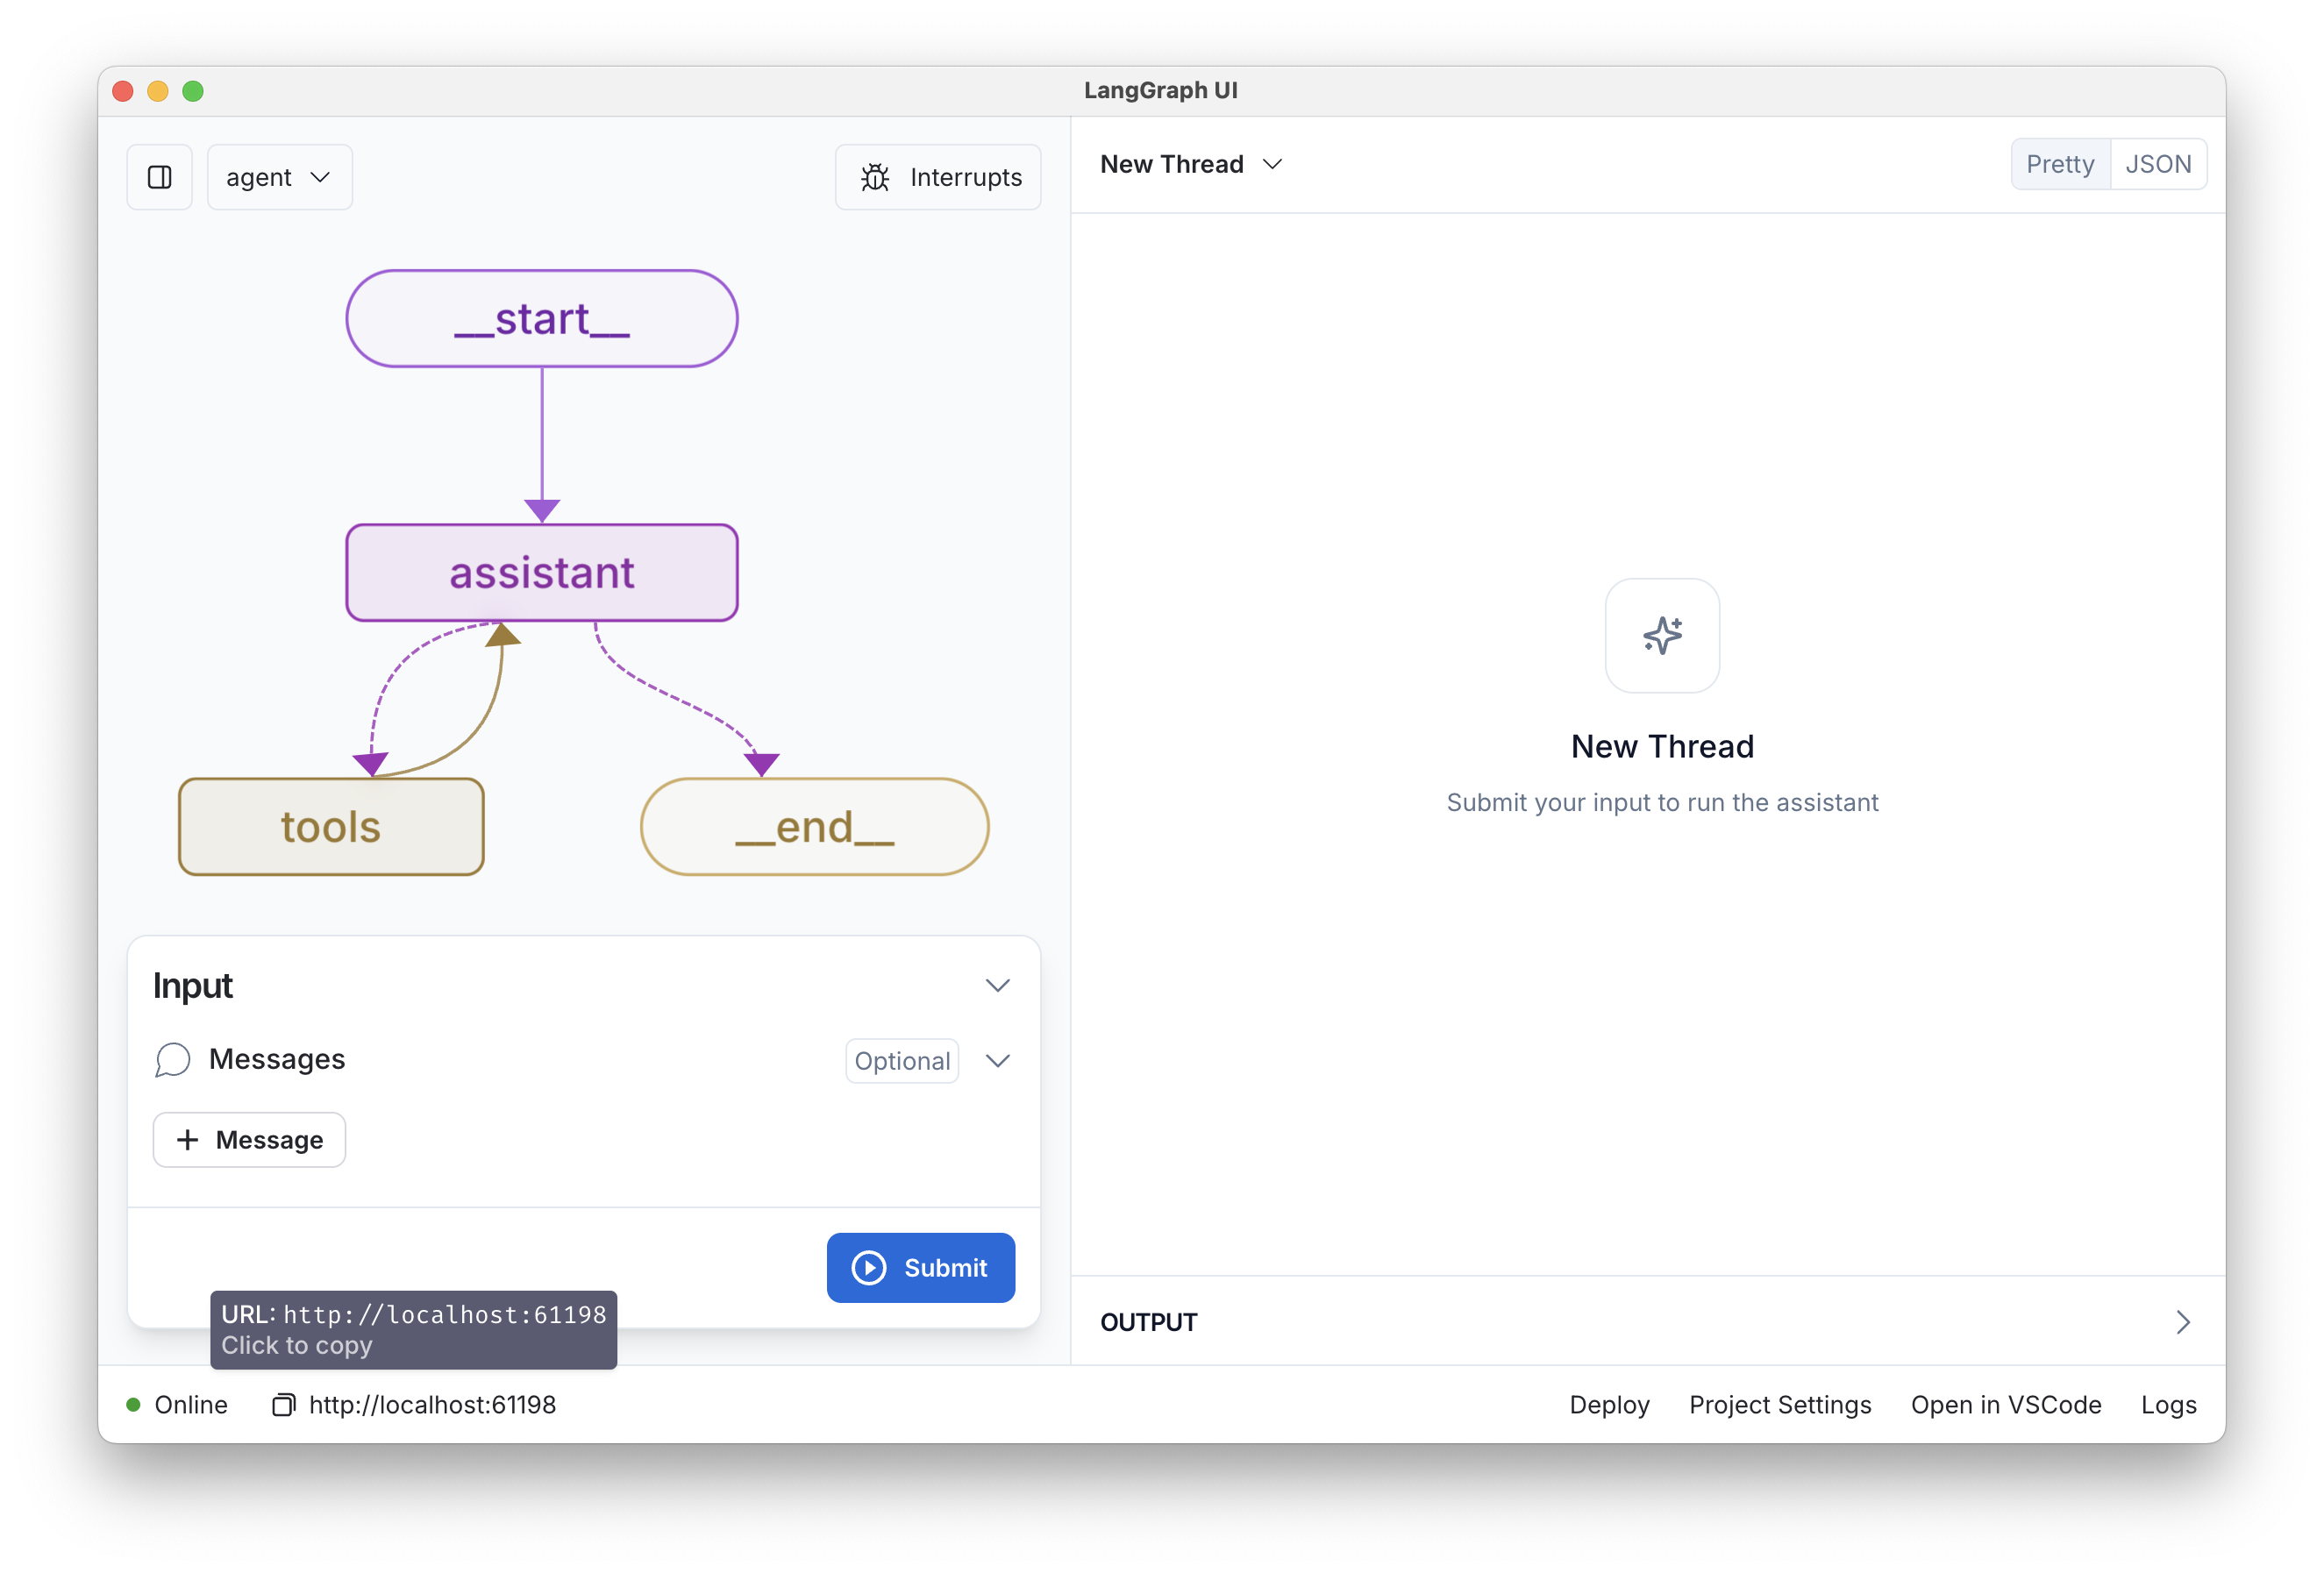

In [3]:
from langgraph_sdk import get_client

In [2]:
# Replace this with the URL of your own deployed graph
URL = "http://localhost:56091"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [9]:
assistants[-3]

{'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
 'graph_id': 'agent',
 'created_at': '2024-08-30T23:58:18.505075+00:00',
 'updated_at': '2024-08-30T23:58:18.505075+00:00',
 'config': {},
 'metadata': {'created_by': 'system'}}

In [3]:
# We create a thread for tracking the state of our run
thread = await client.threads.create()

Now, we can run our agent [with `client.runs.stream`](https://langchain-ai.github.io/langgraph/concepts/low_level/#stream-and-astream) with:

* The `thread_id`
* The `graph_id`
* The `input` 
* The `stream_mode`

We'll discuss streaming in depth in a future module. 

For now, just recognize that we are [streaming](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/) the full value of the state after each step of the graph with `stream_mode="values"`.
 
The state is captured in the `chunk.data`. 

In [4]:
from langchain_core.messages import HumanMessage

# Input
input = {"messages": [HumanMessage(content="Multiply 3 by 2.")]}

# Stream
async for chunk in client.runs.stream(
        thread['thread_id'],
        "agent",
        input=input,
        stream_mode="values",
    ):
    if chunk.data and chunk.event != "metadata":
        print(chunk.data['messages'][-1])

{'content': 'Multiply 3 by 2.', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'cdbd7bd8-c476-4ad4-8ab7-4ad9e3654267', 'example': False}
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_iIPryzZZxRtXozwwhVtFObNO', 'function': {'arguments': '{"a":3,"b":2}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-06c7243c-426d-4c81-a113-f1335dda5fb2', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 3, 'b': 2}, 'id': 'call_iIPryzZZxRtXozwwhVtFObNO', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '988cb170-f6e6-43c1-82fd-309f519abe6d', 'tool_call_id': 'c

## Testing with Cloud

We can deploy to Cloud via LangSmith, as outlined [here](https://langchain-ai.github.io/langgraph/cloud/quick_start/#deploy-from-github-with-langgraph-cloud). 

### Create a New Repository on GitHub

* Go to your GitHub account
* Click on the "+" icon in the upper-right corner and select `"New repository"`
* Name your repository (e.g., `langchain-academy`)

### Add Your GitHub Repository as a Remote

* Go back to your terminal where you cloned `langchain-academy` at the start of this course
* Add your newly created GitHub repository as a remote

```
git remote add origin https://github.com/your-username/your-repo-name.git
```
* Push to it
```
git push -u origin main
```

### Connect LangSmith to your GitHub Repository

* Go to [LangSmith](hhttps://smith.langchain.com/)
* Click on `deployments` tab on the left LangSmith panel
* Add `+ New Deployment`
* Then, select the Github repository (e.g., `langchain-academy`) that you just created for the course
* Point the `LangGraph API config file` at one of the `studio` directories
* For example, for module-1 use: `module-1/studio/langgraph.json`
* Set your API keys (e.g., you can just copy from your `module-1/studio/.env` file)

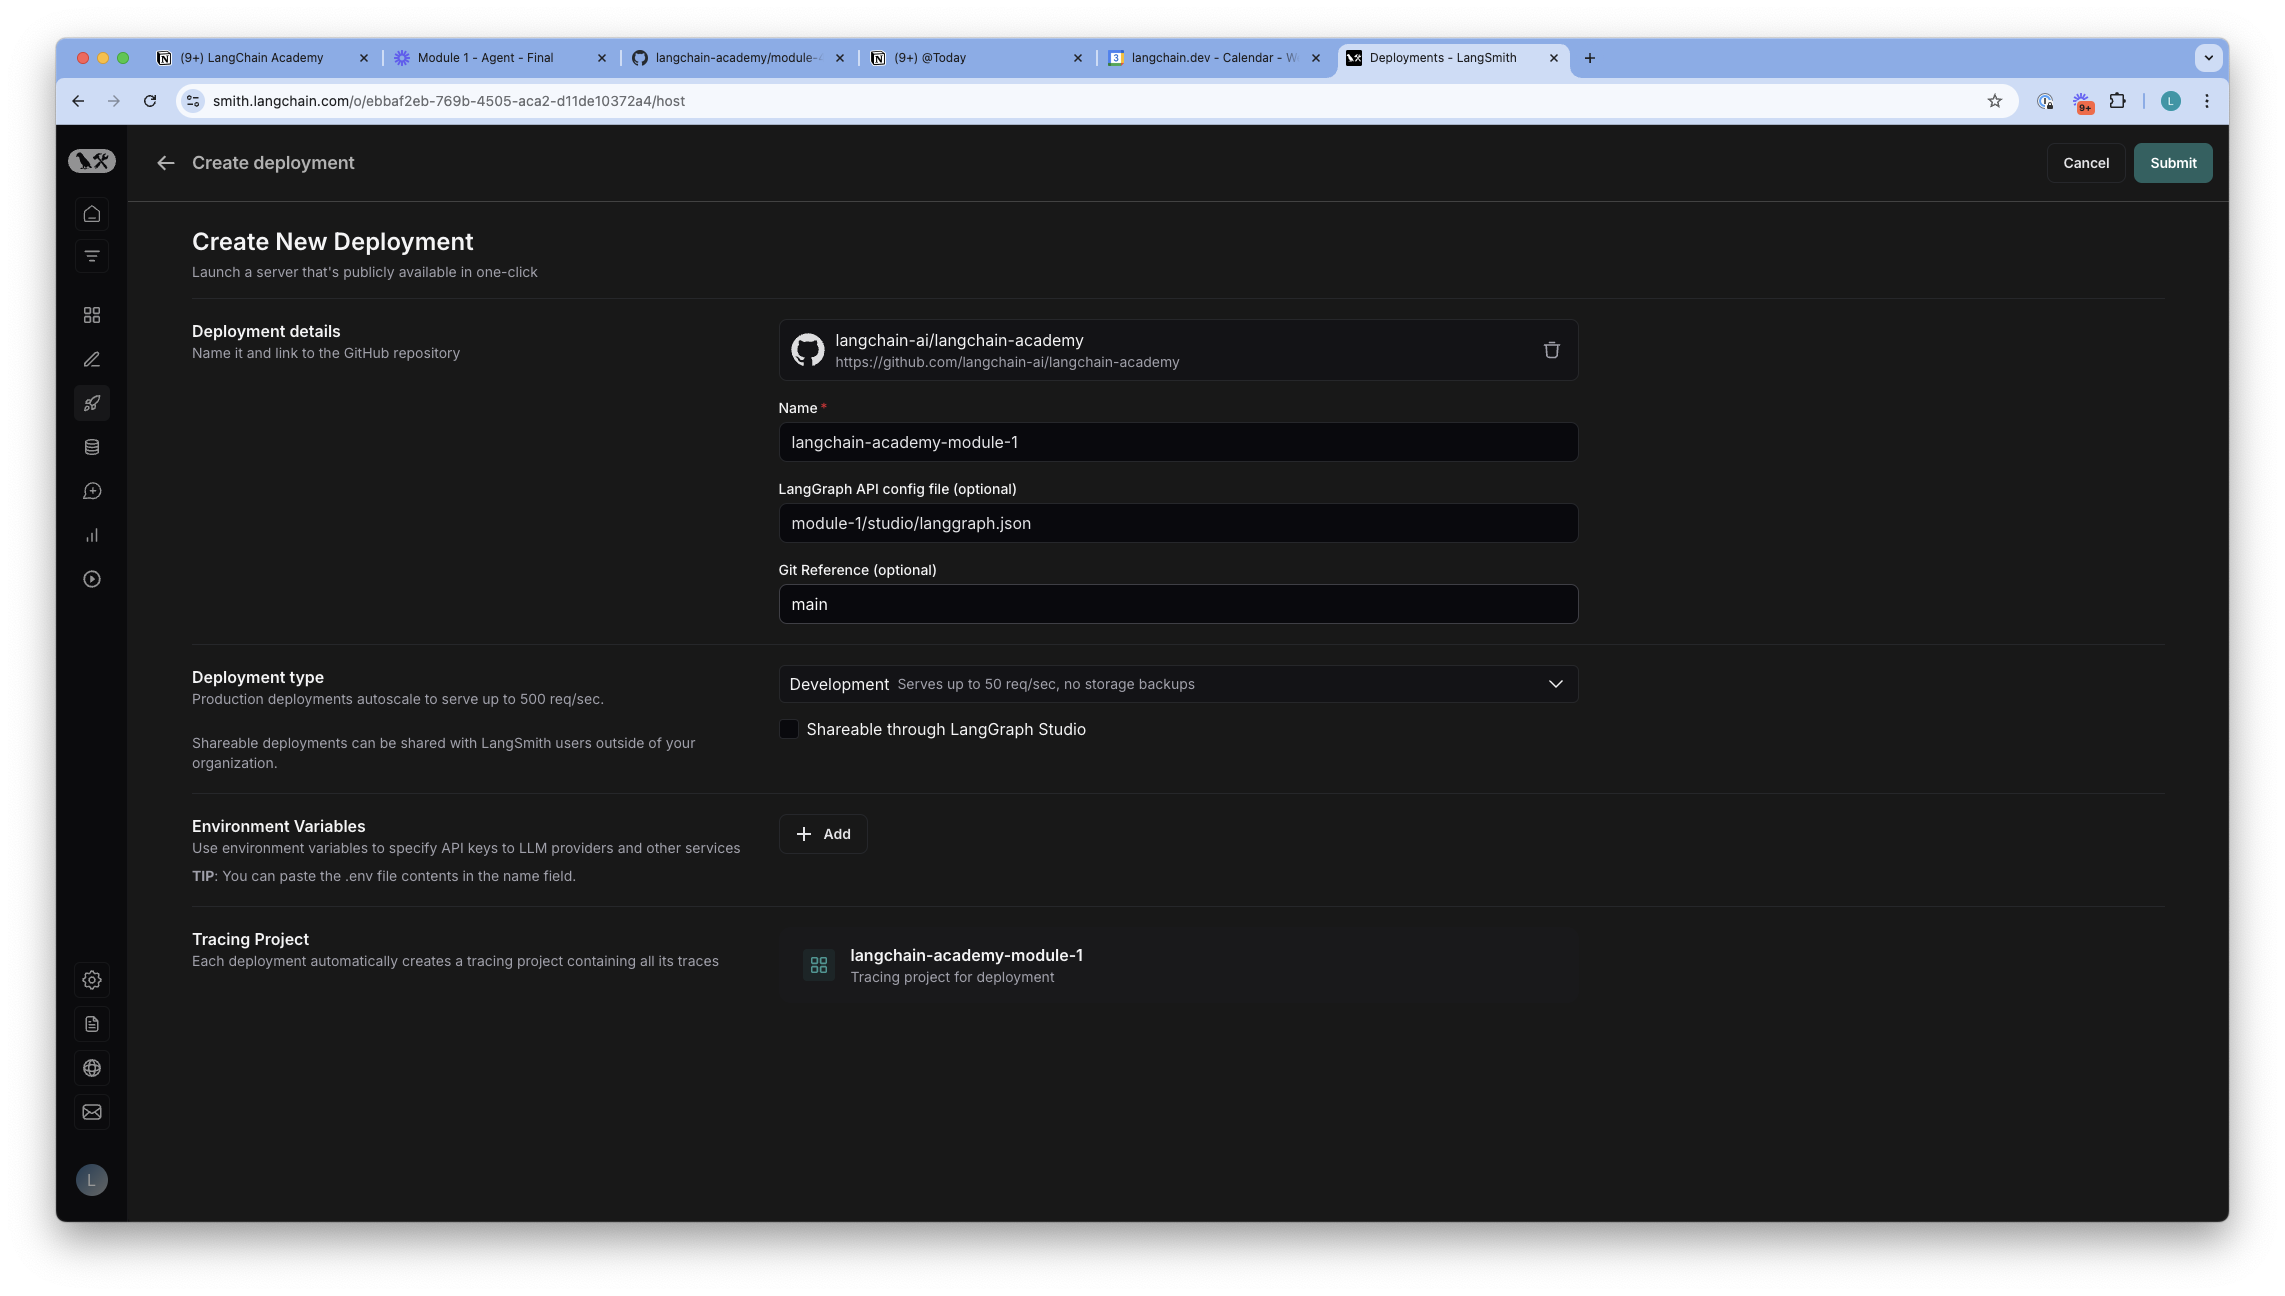

### Work with your deployment

We can then interact with our deployment a few different ways:

* With the [SDK](https://langchain-ai.github.io/langgraph/cloud/quick_start/#use-with-the-sdk), as before.
* With [LangGraph Studio](https://langchain-ai.github.io/langgraph/cloud/quick_start/#interact-with-your-deployment-via-langgraph-studio).

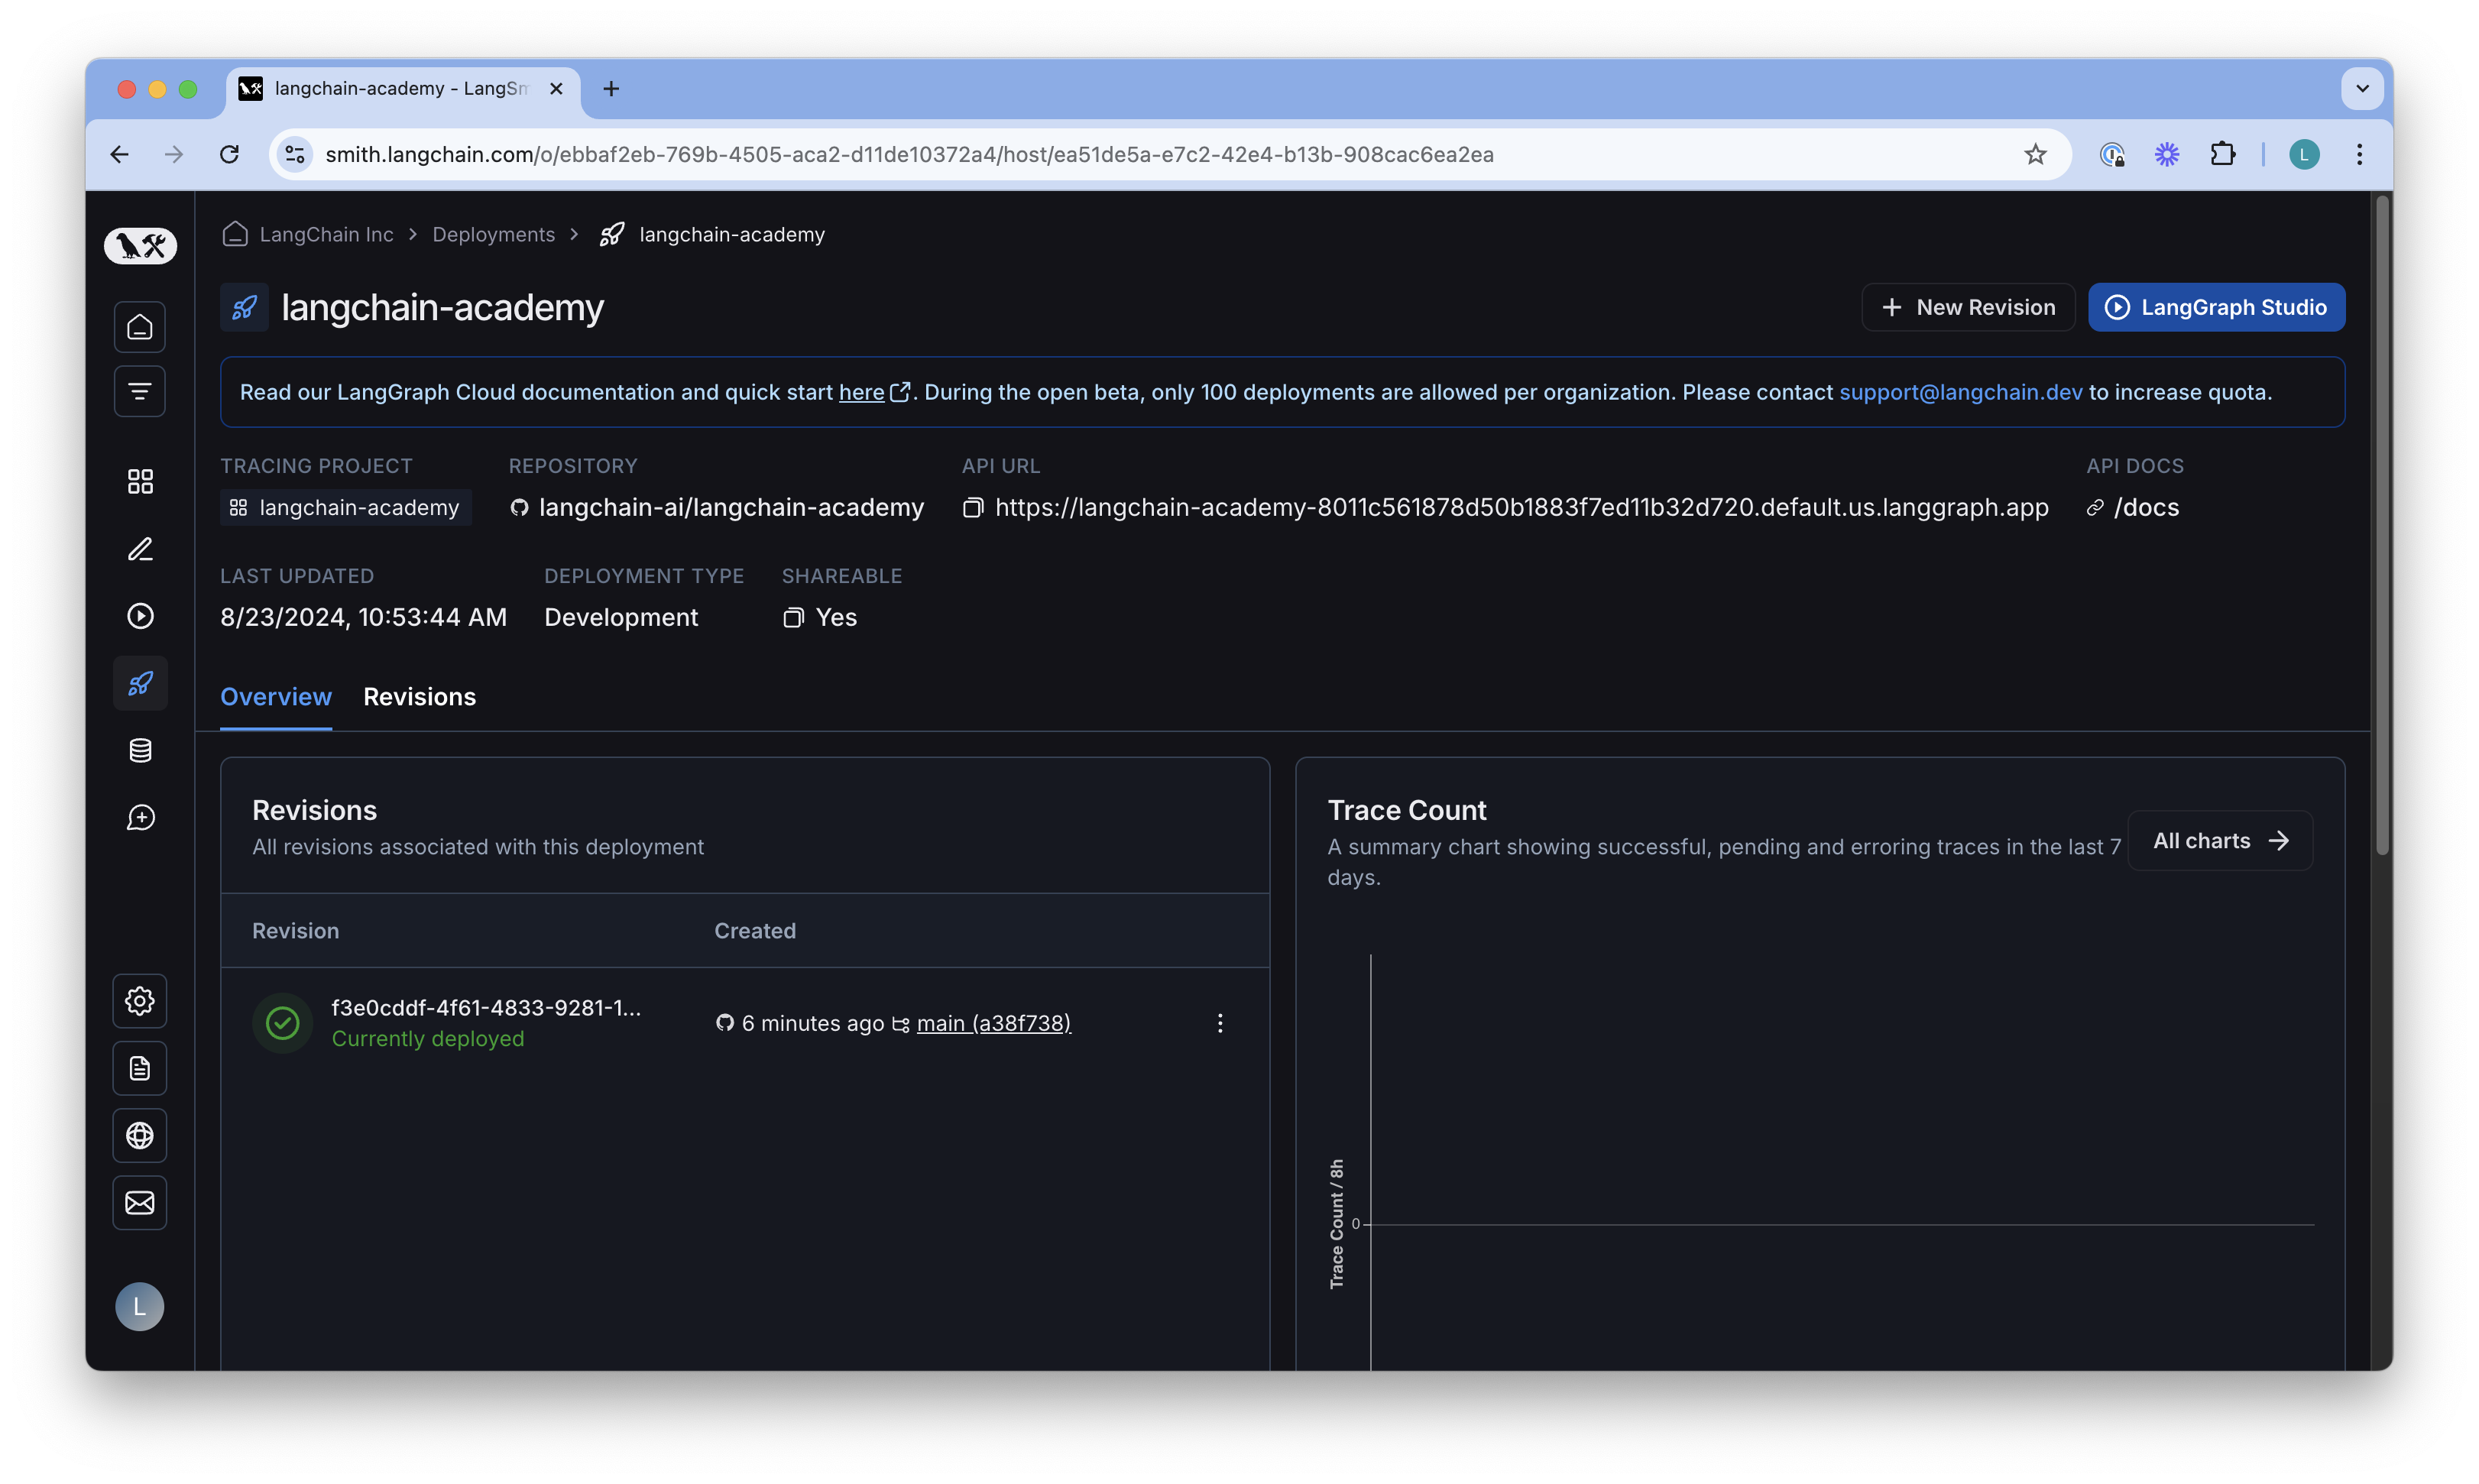

To use the SDK here in the notebook, simply ensure that `LANGSMITH_API_KEY` is set!

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGCHAIN_API_KEY")

In [ ]:
# Replace this with the URL of your deployed graph
URL = "https://langchain-academy-8011c561878d50b1883f7ed11b32d720.default.us.langgraph.app"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [37]:
# Select the agent
agent = assistants[0]

In [38]:
agent

{'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
 'graph_id': 'agent',
 'created_at': '2024-08-23T17:58:02.722920+00:00',
 'updated_at': '2024-08-23T17:58:02.722920+00:00',
 'config': {},
 'metadata': {'created_by': 'system'}}

In [40]:
from langchain_core.messages import HumanMessage

# We create a thread for tracking the state of our run
thread = await client.threads.create()

# Input
input = {"messages": [HumanMessage(content="Multiply 3 by 2.")]}

# Stream
async for chunk in client.runs.stream(
        thread['thread_id'],
        "agent",
        input=input,
        stream_mode="values",
    ):
    if chunk.data and chunk.event != "metadata":
        print(chunk.data['messages'][-1])

{'content': 'Multiply 3 by 2.', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '8ea04559-f7d4-4c82-89d9-c60fb0502f21', 'example': False}
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_EQoolxFaaSVU8HrTnCmffLk7', 'function': {'arguments': '{"a":3,"b":2}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27'}, 'type': 'ai', 'name': None, 'id': 'run-b0ea5ddd-e9ba-4242-bb8c-80eb52466c76', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 3, 'b': 2}, 'id': 'call_EQoolxFaaSVU8HrTnCmffLk7', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '1bf558e7-79ef-4f21-bb66-acafbd04677a', 'tool_call_id': 'c